# Variational Inference

See:
* [Great first resource](http://www.cmap.polytechnique.fr/~zoltan.szabo/jc/2017_05_18_Massil_Achab.pdf)
* [VI: A review for statisticians](https://arxiv.org/pdf/1601.00670.pdf)
* [EL20](https://arxiv.org/pdf/1901.04454.pdf)
* Bayesian Data Analysis Chapter 13 (Gelman)

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Kullback–Leibler (KL) Divergence

The KL divergence measures how similar two probability distributions are. For discrete PDFs this is:

$$
D_{KL}(P || Q) = \sum_{x \in X} P(x) \log \big(\frac{P(x)}{Q(x)}\big)
$$

The divergence is measured in bits of information if the log used is base 2, and nats if it is base $e$. It can be understood as the amount of information gained when moving from $P \rightarrow Q$, or as the amount of information lost when approximating $P$ as $Q$.

In [24]:
def discrete_KL_divergence(p, q):
    assert np.isclose(np.sum(p), 1) and np.isclose(np.sum(q), 1) and len(p) == len(q)
    return np.sum(p * np.log(p / q))

p = np.array([2, 2, 2])
q = np.array([1, 4, 2])
p, q = p / np.sum(p), q / np.sum(q)

print(discrete_KL_divergence(p, q), discrete_KL_divergence(q, p))

print(discrete_KL_divergence(p, p))

# As always if you actually want to use this, use scipy's.
assert np.isclose(scipy.stats.entropy(q, p), discrete_KL_divergence(q, p))

0.15415067982725839 0.14291239755557528
0.0


Some interesting properties:
* $D_{KL} = 0$ iff $Q(x) = P(x)$ for all $x$ (as $\log(1) = 0$).
* $D_{KL} >= 0$ see [Gibb's inequality](https://en.wikipedia.org/wiki/Gibbs%27_inequality)
* It is not symmetric! Be careful that this isn't the divergence *between* $P$ and $Q$ but rather the divergence *from* $P$ to $Q$.
* It is undefined if $Q(x) = 0$ where $P(x) \neq 0$.

# Variational Inference Theory

A tiny summary:

We assume a simple analytic form for the posterior, and try to fit its parameters to the information we have. *EL20 paper*

A short summary:
1. We are doing Bayesian inference. We want to find the posterior distribution $P(z | x)$ of some latent variables given priors and some data.
2. This is hard because of the evidence term in Bayes theorem which requires integrals.
3. Instead we pick some model for our posterior distribution. $Q(z | \alpha)$ where $\alpha$ depends on our model of $Q$ e.g. if the model is a multivariate normal, $\alpha$ contains a mean vector and a covariance matrix.
4. We then try optimize $\alpha$ so that $Q$ is similar to $P(z | x)$, by minimzing $D_{KL}(Q || P)$.
5. This sounds hard because we don't know $P(z | x)$ - if we did we wouldn't need to do all this work. However, it turns out that minimzing $D_{KL}(Q || P)$ is the same as maximizing the ${\rm ELBO}(Q(z)) = \mathbf{E}^Q[\log(P(x, z))] - \mathbf{E}^Q[\log(Q(z))]$ the components of which we do know.

## A Reminder About Bayesian Inference

In Bayesian inference we have some observed variables $x$ and some hidden or [latent](https://en.wikipedia.org/wiki/Latent_variable) variables $z$ that encode the structure behind $x$. E.g. is cosmology $x$ are your observations (galaxies, CMB, etc) and $z$ are the cosmological parameters ($\Omega_M$, $\sigma_8$, etc). We want to constrain $z$ using the data $x$.

[Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) tells us that:

$$
P(z | x) = \frac{P(z) P(x | z)}{P(x)}
$$

or in english, the posterior probability of the parameters $z$ given the data $x$ is equal to the prior probability of that $z$ multiplied by the likelihood of that data given those parameters. This is normalized by the evidence $P(x)$. Remember, we want to learn the posterior $P(z | x)$.

We can remove the conditionals, $P(a | b)$, and instead express the posterior as a function of joint, $P(a, b)$, distributions.

$$
P(z | x) = \frac{P(x, z)}{\int P(x, z)\ dz}
$$

Computing this in practice is hard because we would need to do that integral over the potentially high dimensional $z$ space. We need to do something different.

## How VI applies to BI

VI is a way to compute approximate posteriors $P(z | x)$ without doing that integral. In that sense it is the same as MCMC, however it goes about in completely different ways.

1. Assume that the posterior $P(z | x)$ can be modelled by some distribution $Q$. A common assumption is that each $z_i$ is independent and let's say that they are gaussian. In that that case $Q(\mu, \Sigma)$ where $\mu$ is a vector of the means (the same length as $z$) and $\Sigma$ a diagonal matrix (because the $z_i$ have no covariance) of the same dimension.
2. Optimize the choice of those parameters ($\mu$, $\Sigma$) to minimize $D_{KL}(P(z | x) || Q(z | \mu, \Sigma)$.
3. Claim that the best fit model $Q^\ast$ is a good approximation to the posterior and use that.

**N.B.** with $Q$ we are trying to approximate the *posterior* on the latent variables. I misunderstood this at first.

The hardest part of this appears to be step 2. How can we compute the KL divergence if we don't know $P(z | x)$?

## Evidence Lower Bound (ELBO)

Assume we have some proposed $Q(z)$ as our model for the posterior. How can we compare this to the true posterior $P(z | x)$ (which we don't know)? **N.B.** as above remember that both of these are probabilities for the latent variable $z$.

$$
\begin{align}
&\ \ \ D_{KL}(Q(z) || P(z | x)) \\
&= \int Q(z) \log \big(\frac{Q(z)}{P(z | x)}\big) dz \\
&= \int Q(z) ( \log(Q(z)) - \log(P(z | x)) ) dz \\
&= \int Q(z) \log(Q(z)) dz - \int Q(z) \log(P(z | x)) dz
\end{align}
$$

These transformations are all good but we are still stuck with the posterior which we can't compute because of the integral in the denominator... 

Let's make the notation a bit more concise using expected values. Remember:

$$
\mathbf{E}^P[X] = \int P(x) x dx \\
\mathbf{E}^P[g(X)] = \int P(x) g(x) dx
$$

we say, the expectation value of the function $g$ with the probability function $P$ is the integral on the RHS. So similarly,

$$
\int Q(z) \log(P(z | x)) = \mathbf{E}^Q[\log(P(z | x)]
$$

With this notation,

$$
\begin{align}
&\ \ \ D_{KL}(Q(z) || P(z | x)) \\
&= \mathbf{E}^Q[\log(Q(z))] - \mathbf{E}^Q[\log(P(z | x))] \\
&= \mathbf{E}^Q[\log(Q(z))] - \mathbf{E}^Q[\log(\frac{P(x, z)}{P(x)})] \\
&= \mathbf{E}^Q[\log(Q(z))] - \mathbf{E}^Q[\log(P(x, z)) - \log(P(x))] \\
&= \mathbf{E}^Q[\log(Q(z))] - \mathbf{E}^Q[\log(P(x, z))] + \mathbf{E}^Q[\log(P(x))]
\end{align}
$$

but in the final term, $P(x)$ is not a function of $z$ and so 
$$
\int Q(z) \log(P(x)) dz = \log(P(x)) \int Q(z) dz = \log(P(x))
$$

therefore,

$$
D_{KL}(Q(z) || P(z | x)) = \mathbf{E}^Q[\log(Q(z))] - \mathbf{E}^Q[\log(P(x, z))] + \log(P(x))
$$

All we have done in this section is replaced the posterior (LHS in bayes) with a joint (representing the prior and the likelihood) and the evidence (the combination of which is the RHS in bayes). The joint can easily be computed ($P(x, z) = P(z) P(x | z)$, where we chose the prior and can compute the likelihood) and while the evidence cannot be computed it is now just a constant - it is not a function of our choice of $z$.

The $z$ that minimizes the KL divergence between the posterior and $Q$ will therefore also minimize the RHS. In a minimization problem we can remove any constants and so we finally have got rid of the pesky evidence. We now just need to minimize,

$$
\mathbf{E}^Q[\log(Q(z))] - \mathbf{E}^Q[\log(P(x, z))]
$$

Note that while this looks a bit like a KL divergence it isn't. The main reason for this is that the two terms are not defined over the same space - $Q(z)$ and $P(x, z)$ - and $P$ is not normalized.

In practice, people tend to talk above maximizing the negative of this, which they call the ${\rm ELBO}$.

$$
{\rm ELBO}(Q(z)) = \mathbf{E}^Q[\log(P(x, z))] - \mathbf{E}^Q[\log(Q(z))]
$$

The $z^\ast$ that maximizes this is also the $z^\ast$ that minimizes the KL divergence and that optimizes the similaritiy between the true posterior and our model of it.

The name, Evidence Lower Bound, comes from the fact that ELBO is always less than or equal to the log evidence ($P(x)$). It is a lower bound on the evidence.

$$
\begin{align}
D_{KL}(Q(z) || P(z | x)) &= -{\rm ELBO}(Q) + \log(P(x)) \\
\log(P(x)) &= D_{KL}(Q(z) || P(z | x)) + {\rm ELBO}(Q) \\
\therefore \log(P(x)) &>= {\rm ELBO}(Q)
\end{align}
$$

this inequality is because the KL divergence is always non-negative. 

## Computing ELBO in practice

We still need to do integrals over $z$ space. Is'nt that a problem for high dimensional space?

http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf

# Family of Distributions

We need to choose what form our $Q(z)$ takes - is it a multivariate gaussian (optionally with a diagonal covariance matrix), is it etc etc.

A popular (and simple) choice is the mean-field variational family.

## Mean-field variational family

In the MFVF we assume that the latent variables are mutually independent:

$$
Q(z) = \prod_{i=1}^{m} q_i(z_i)
$$

Remember again that this has nothing to do with the data $x$. This is just the distribution of the latent variables which we will get close to the goal distribution (the posterior) bu maximising the ELBO.

We then need to specify what form each of the $q_i$ take -- are they gaussian, uniform, categorical, etc. Once we make this choice we can tweak the parameters that describe each $q_i$ to reduce the KL/increase the ELBO.

For example, let's assume that we decide that the ith latent variable is best described by a gaussian. Then,

$$
q_i(z_i) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\bigg(- \frac{(z_i - \mu_i)^2}{2 \sigma_i^2}\bigg)
$$

Maybe we decide that all $q_i$ are gaussian - note that this is $m$ 1d gaussians rather than 1 $m$d gaussian as there are independent. We then have, (see [here](../gaussian_processes/multivariate_gaussian.ipynb))

$$
\begin{align}
Q(z) &= \prod_{i=1}^{m} \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp\bigg(- \frac{(z_i - \mu_i)^2}{2 \sigma_i^2}\bigg) \\
\log Q(z) &= - \sum_{i=1}^{m} \log(2 \pi \sigma_i^2) + \frac{(z_i - \mu_i)^2}{2 \sigma_i^2}
\end{align}
$$



Let's optimize this. To do this we need to know the likelihood and prior to get $P(x, z)$. Assume that this is also gaussian, but with some covariance.

$$
\begin{align}
P(z, x) &= \frac{1}{\sqrt{(2 \pi)^k |\Sigma|}} \exp\bigg(\frac{1}{2}(z - \mu)^T \Sigma^{-1} (z - \mu)\bigg) \\
\log P(z, x) &= -\frac{1}{2} (k \log (2 \pi) + \log (| \Sigma |) + (z - \mu)^T \Sigma^{-1} (z - \mu) )
\end{align}
$$

We then want to maximise,

$$
\begin{align}
{\rm ELBO}(Q(z)) = \mathbf{E}^Q[\log(P(x, z))] - \mathbf{E}^Q[\log(Q(z))]
\end{align}
$$

Because everything is gaussian we could do this analytically. But I will just do this numerically...

# Example 1: KL fit to Posterior

This doesn't actually do any inference. It just shows, given a posterior, the best fit of a mean-field gaussian family to it.

It also takes some other things for granted that are wrong or simplifications. Just look at the pictures.

In [138]:
dims = 2
p_mean, p_cov = np.array([0, 0]), np.array([[1, 0], [1, 2]])
evidence = 150 # We don't know what this is 

prior_and_liklihood = lambda x: scipy.stats.multivariate_normal(p_mean, p_cov).pdf(x) * evidence

def q(means, variances):
    q = scipy.stats.multivariate_normal(mean=means, cov=np.diag(variances))
    return lambda x: q.pdf(x)

x, y = np.meshgrid(np.linspace(-3, 3), np.linspace(-3, 3))
eval_locations = np.concatenate((x[:,:,np.newaxis], y[:,:,np.newaxis]), axis=2)

def compare(means, variances):
    q_res = q(means, variances)(eval_locations)
    p_res = prior_and_liklihood(eval_locations)
    
    p_res, q_res = p_res / np.sum(p_res), q_res / np.sum(q_res)

    fig, axes = plt.subplots(1, 2)
    img = axes[1].imshow(q_res, cmap="Reds")
    cbar = fig.colorbar(img, fraction=0.046, pad=0.04)
    img = axes[0].imshow(p_res, cbar.get_cmap(), vmin=cbar.get_clim()[0], vmax=cbar.get_clim()[1])
    
    
    print(scipy.stats.entropy(
        p_res.flatten(),
        q_res.flatten(),
    ))

0.5058327043148416


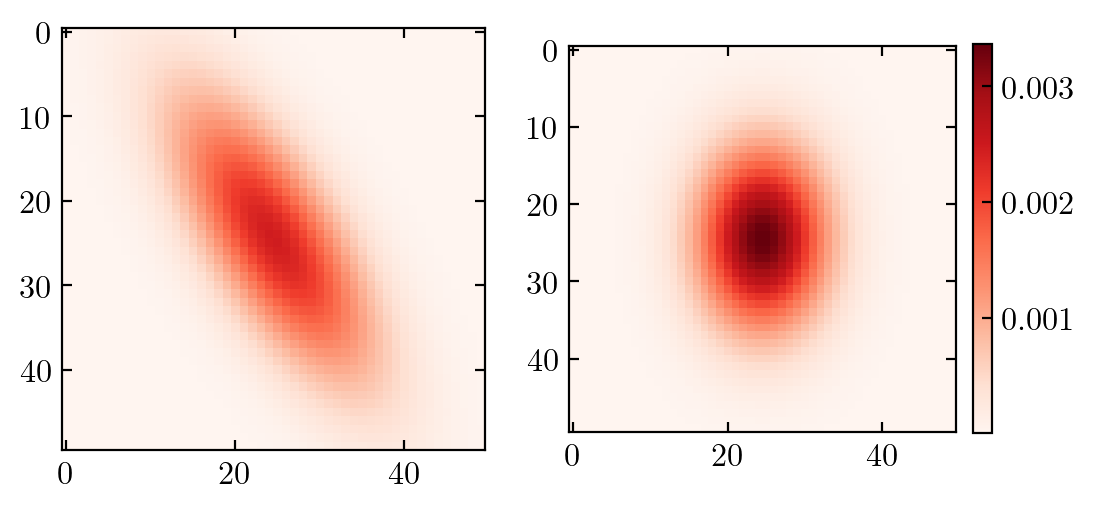

In [139]:
def f(theta):
    means, variances = theta[:dims], theta[dims:]
    # Be careful that you get this the right way around!
    return scipy.stats.entropy(
        q(means, variances)(eval_locations).flatten(),        
        prior_and_liklihood(eval_locations).flatten(),
    )

res = scipy.optimize.minimize(
    f,
    np.ones(dims*2)
)
assert res.success == True

best_means, best_variances = res.x[:dims], res.x[dims:]
compare(best_means, best_variances)

# Incomplete Example

This follows section 3 in [VI: A review for statisticians](https://arxiv.org/pdf/1601.00670.pdf).

The data is generated by a **mixture of k unit-variance gaussians**, created in the following way:
1. Select the means for the gaussians, $\mu_k \sim \mathcal{N}(0, \sigma^2)$. 
2. Select which gaussian each $x_i$ is drawn from $c_i \sim {\rm Categorical}(1/k, ..., 1/k)$ and represent this as a vector with 0s everywhere except the chosen category which is 1. 
3. Draw from that gaussian $x_i \sim \mathcal(c_i^T \mu, 1)$.

In summary:
* $\mu_k \sim \mathcal{N}(0, \sigma^2)$ - to create a K long vector of the means.
* $c_i \sim {\rm Categorical}(1/k, ..., 1/k)$ - to create a K long vector representing which gaussian the ith draw is from.
* $x_i \sim \mathcal(c_i^T \mu, 1)$ - to draw from that gaussian. Do this n times to generate the data.

Here, $x_i | c_i, \mu$ therefore $x | c, \mu$. So the latent variables are the $k$ means and the $n$ class assignments. There is also a hyperparameters $\sigma^2$.

We now want to build a model to determine these $k + n$ latent variables $(\mu, c)$

As this model uses gaussians and they are easy to work with it seems like a gaussian mixture model is reasonable for our $Q$.

Remember that we want to maximise the ${\rm ELBO}(Q(z))$,

$$
{\rm ELBO}(Q(z)) = \mathbf{E}^Q[\log(P(x, z))] - \mathbf{E}^Q[\log(Q(z))]
$$

....